<a href="https://www.kaggle.com/code/macmyller/pdi-project?scriptVersionId=202149895" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Imports

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

# Utils

In [ ]:
# Setting up file paths
train_path = '/kaggle/input/kermany2018/OCT2017 /train'
test_path = '/kaggle/input/kermany2018/OCT2017 /test'
val_path = '/kaggle/input/kermany2018/OCT2017 /val'

In [ ]:
categories = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
num_classes = 4
# image_size = (128, 128, 3)
batch_size = 84

In [ ]:
# EDA: Count number of images per category in each set
def count_images_in_directory(directory):
    category_count = {}
    for category in categories:
        category_path = os.path.join(directory, category)
        category_count[category] = len(os.listdir(category_path))
    return category_count

# Get image distribution for train, validation, and test sets
train_distribution = count_images_in_directory(train_path)
test_distribution = count_images_in_directory(test_path)
val_distribution = count_images_in_directory(val_path)
train_distribution, test_distribution, val_distribution

In [ ]:
from PIL import Image

image_file_sample = f'{val_path}/CNV/CNV-6294785-1.jpeg'
img = Image.open(image_file_sample)

plt.imshow(img)
# plt.title(f"Label: {categories[label]}")
# plt.axis("off") # Remover os eixos
plt.show()

# Load Data

In [ ]:
directory = train_path
image_size = (128, 128)
val_split = 0.0184
seed = 42
# subset = 'both' 

# %time dataset, val_dataset = tf.keras.utils.image_dataset_from_directory(directory, validation_split=val_split, subset=subset, batch_size = batch_size, image_size = image_size, seed=seed)


In [ ]:
# normalization_layer = tf.keras.layers.Rescaling(1./255)
# normalized_ds = full_dataset.map(lambda x, y: ( normalization_layer(x),y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

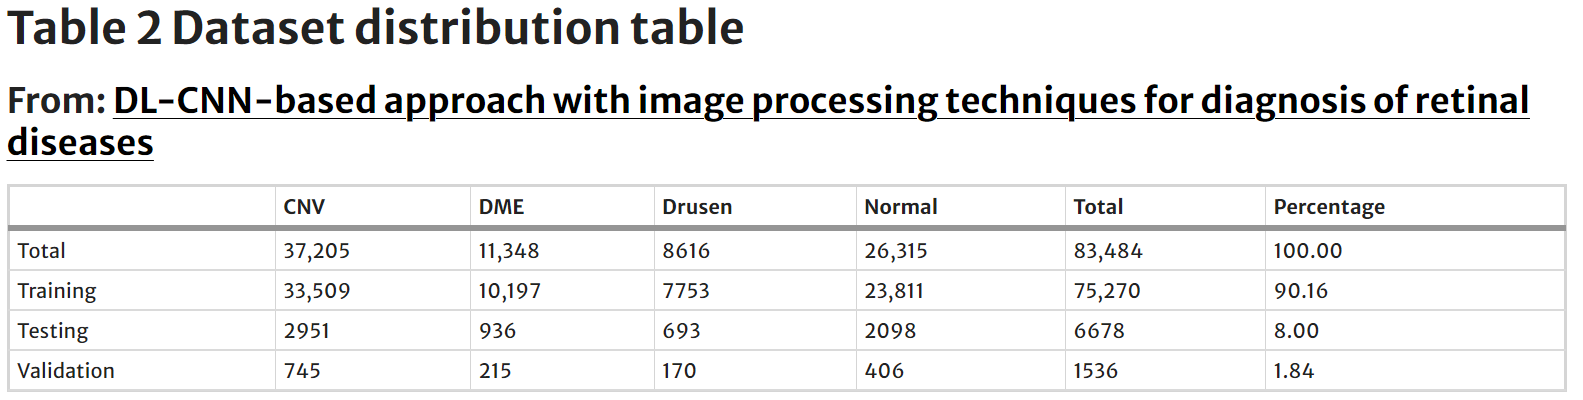

In [ ]:
# TODO: FAZER O MESMO SPLIT DOS DADOS QUE FOI FEITO NO ARTIGO

# Preprocessing

Etapas para pré-processamento de dados:

1.
Leia arquivos do diretório.

2.
Aplique o redimensionamento de cada imagem para 150 × 150 pixels.

3.
Aplique a operação CentreCrop com dimensões finais de 128 × 128 pixels a cada imagem.

4.
Converta a imagem para o tipo de dados tensor para compatibilidade com o modelo.

5.
Normalize a imagem subtraindo a média de cada valor de pixel e dividindo o resultado pelo desvio padrão usando a transformação padrão.



In [ ]:
# TODO: PREPROCESSAR AS IMAGENS

Etapas para aprimoramento de imagem:

1.
Leia arquivos do diretório.

2.
Aplique filtro de desfoque médio para suavizar.

3.
Converta para escala de cinza para operações futuras.

4.
Aplique CLAHE sobre a imagem para melhorar o contraste baixo.

5.
Limiar de imagem por limites de corte de limiar adequados.

6.
Remova ruídos e quebras adicionais na estrutura por meio de operação de morfologia.

7.
Extraia contornos da saída acima para extrair bordas da camada da retina (as outras técnicas de detecção de bordas não foram úteis, conforme discutido).

8.
Desenhe contornos na imagem original para permitir bordas e estruturas de camadas.

9.
Aplique outras transformações como na etapa anterior, incluindo redimensionamento, corte central e normalização.



In [ ]:
# TODO: APRIMORAR AS IMAGENS

# Convolutional Neural Network Architectures

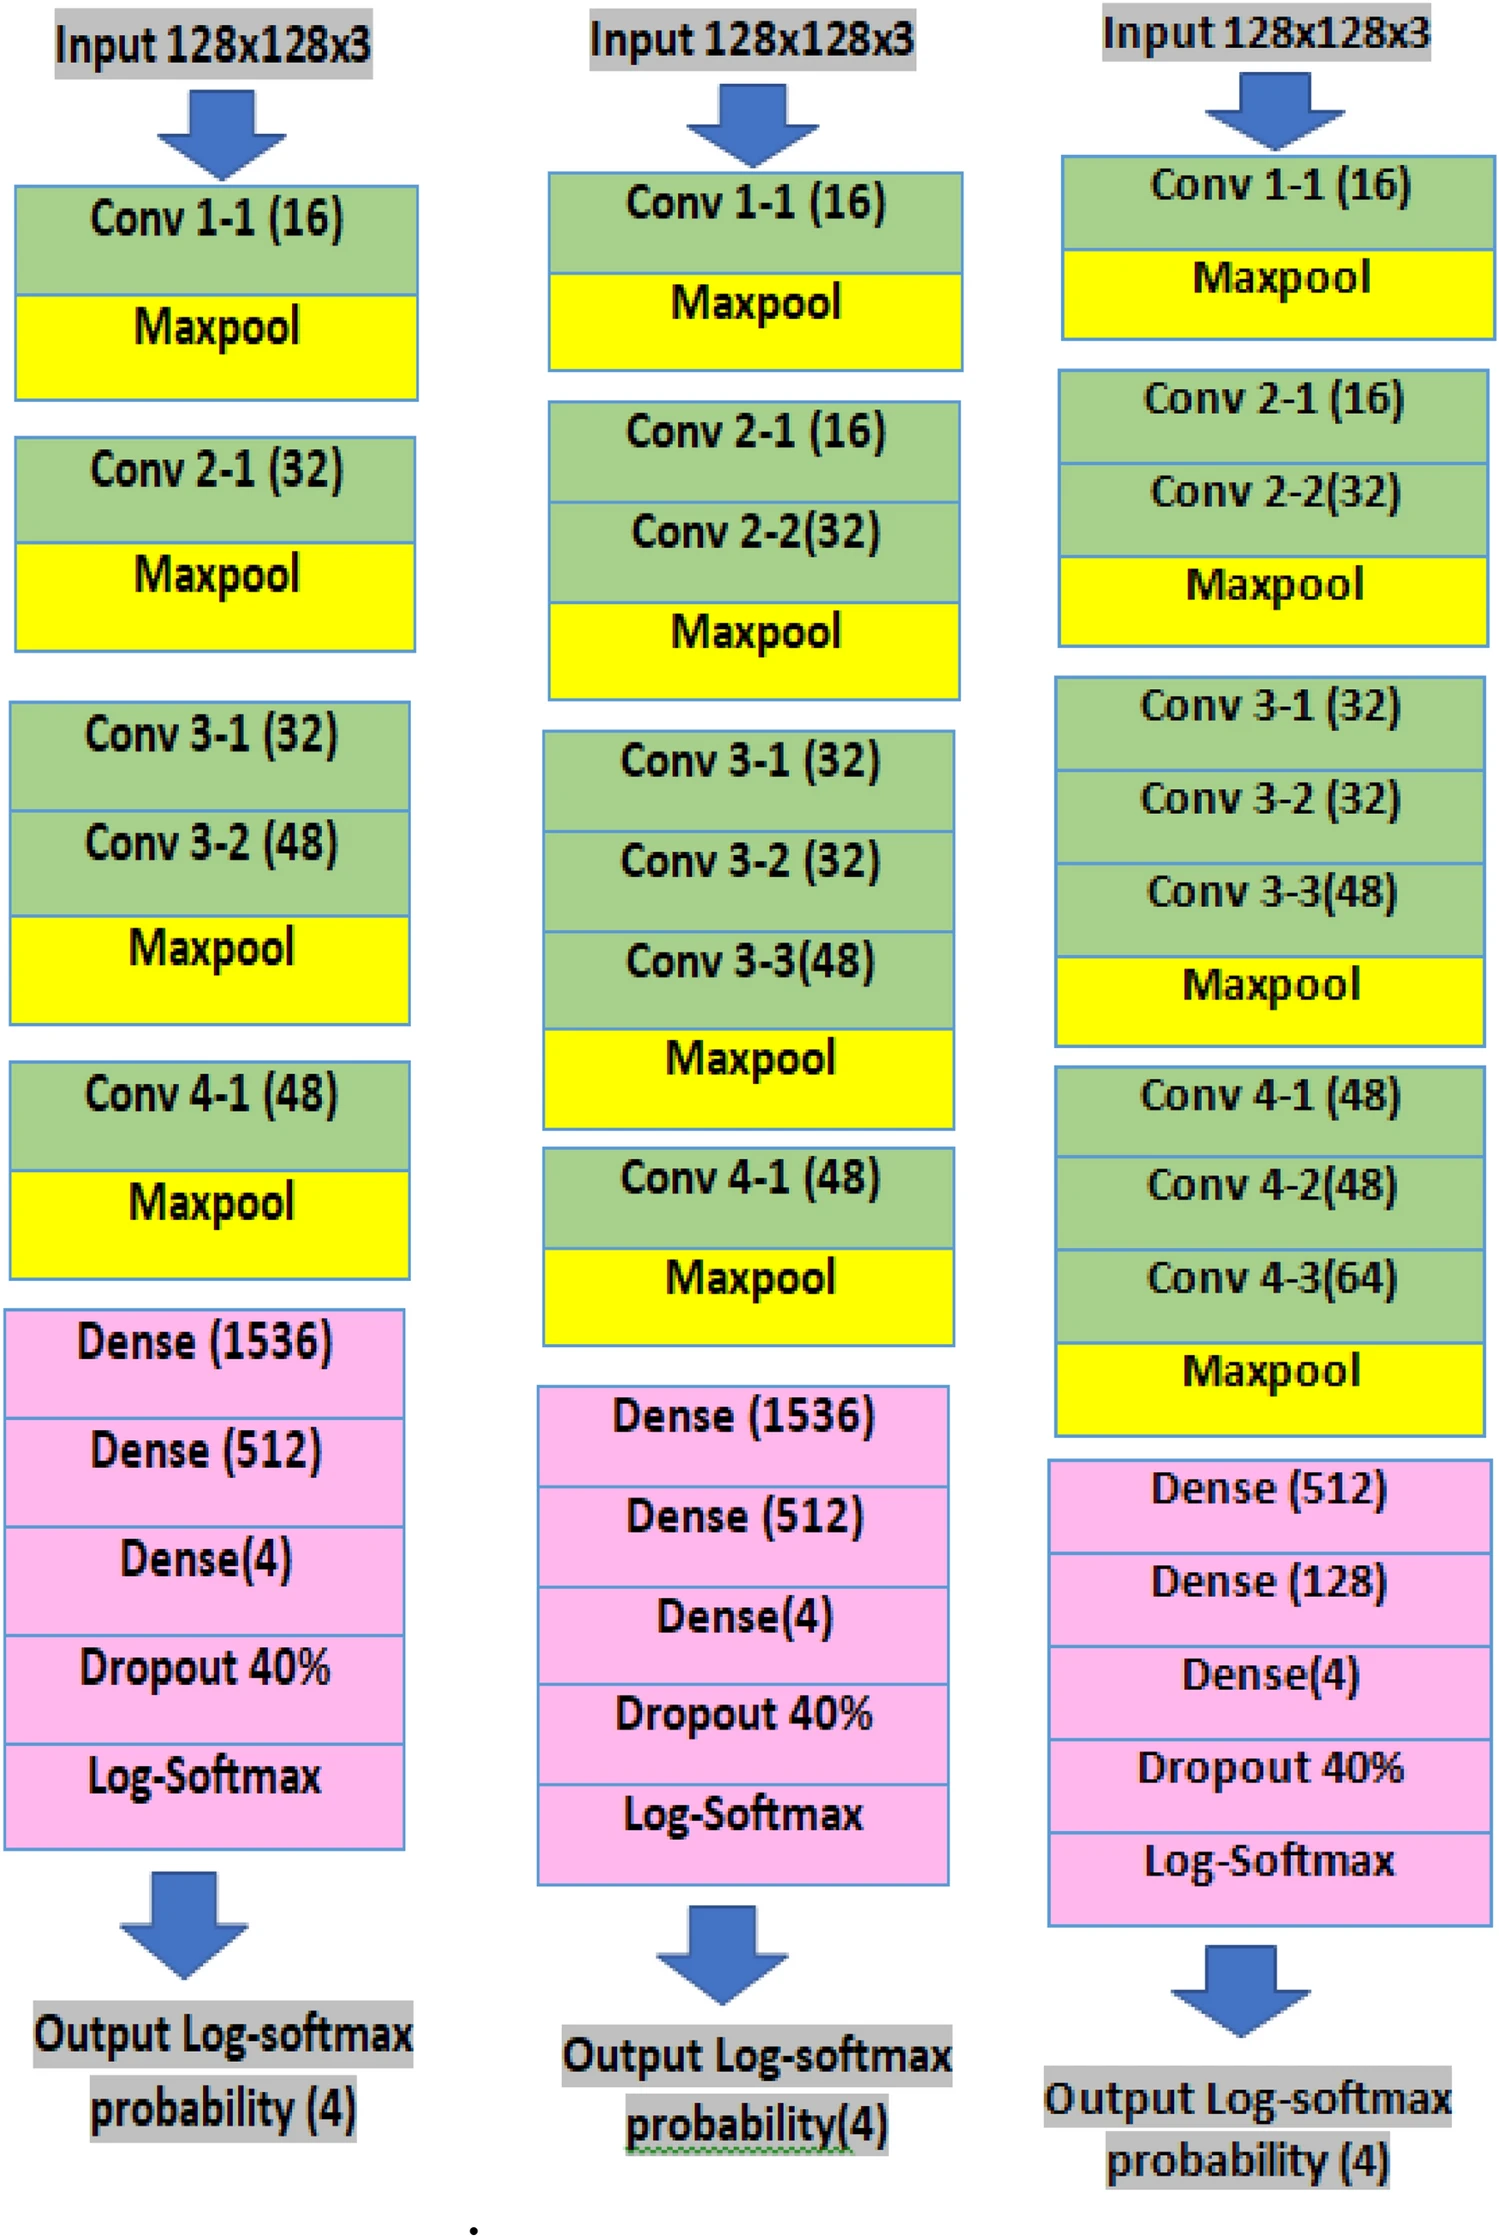

## Architectures used in the article (with PyTorch)

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split

# Transformações do dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Carregar o dataset
data_directory = train_path
dataset = datasets.ImageFolder(root=data_directory, transform=transform)

In [ ]:
import math 

train_dataset, test_dataset, val_dataset = random_split(dataset, [0.9016, 0.08, 0.0184])

batch_size = 84  # Tamanho do batch

# Criar DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) 
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
from collections import Counter

# Função para calcular a distribuição de classes
def calculate_class_distribution(dataset):
    labels = [label for _, label in dataset]  # Extrai os rótulos das amostras
    return Counter(labels)  # Conta a ocorrência de cada classe

# Calcular a distribuição de classes em cada dataset
print("Train distribution")
%time train_distribution = calculate_class_distribution(train_dataset)
print("Val distribution")
%time val_distribution = calculate_class_distribution(val_dataset)
print("Test distribution")
%time test_distribution = calculate_class_distribution(test_dataset)


In [ ]:
class_names = dataset.classes

data = {
    'Train': [train_distribution.get(i, 0) for i in range(4)],
    'Validation': [val_distribution.get(i, 0) for i in range(4)],
    'Test': [test_distribution.get(i, 0) for i in range(4)]
}

df_distribution = pd.DataFrame(data, index=class_names)
df_distribution.loc["Total"] = df_distribution.sum()
df_distribution["Total"] = df_distribution.sum(axis=1)

df_distribution.T * 84

In [ ]:
len(train_dataset), len(test_dataset), len(val_dataset)

In [ ]:
# plt.imshow(img.permute(1, 2, 0))
# type(img)

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Definindo a arquitetura da CNN
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(1, 1))
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 1))
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, 1))
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=48, kernel_size=(1, 1))
        self.conv5 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=(1, 1))

        # Calcular o tamanho da saída da última camada convolucional
        self._to_linear = None
        self._initialize_weights()

    def _initialize_weights(self):
        # Cria uma entrada fictícia para calcular o tamanho da saída da camada convolucional
        x = torch.randn(1, 3, 128, 128)  # Um exemplo com batch size 1
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        self._to_linear = x.numel()  # Número total de elementos na saída

        # Definir as camadas totalmente conectadas
        self.fc1 = nn.Linear(self._to_linear, 1536)
        self.fc2 = nn.Linear(1536, 512)
        self.fc3 = nn.Linear(512, 4)  # 4 classes: CNV, DME, drusen, normal

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(x.size(0), -1)  # Achatar o tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)  # Saída logits

In [ ]:
# Hiperparâmetros
learning_rate = 0.001
epochs = 3  # Modifique conforme necessário

# Instanciando o modelo, critério de perda e otimizador
model = CNNModel()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Treinamento
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zerar gradientes
        outputs = model(inputs)  # Forward pass
        loss = criterion(F.log_softmax(outputs, dim=1), labels)  # Calcular a perda
        loss.backward()  # Backward pass
        optimizer.step()  # Atualizar pesos
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')

In [ ]:
# Validação
model.eval()
val_loss = 0.0
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        loss = criterion(F.log_softmax(outputs, dim=1), labels)
        val_loss += loss.item()

print(f'Validation Loss: {val_loss/len(val_loader):.4f}')

In [ ]:
# Teste
test_loss = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(F.log_softmax(outputs, dim=1), labels)
        test_loss += loss.item()

print(f'Test Loss: {test_loss/len(test_loader):.4f}')

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

def calculate_metrics(loader, model):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Pegar a classe com maior probabilidade
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calcular métricas
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)
    precision = precision_score(all_labels, all_preds, average='weight, zeroed', zero_division=1)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)

    # Calcular AUC, considerando um problema de classificação multi-classe
    # Isso envolve usar a codificação one-hot para as classes
    all_labels_one_hot = torch.zeros(len(all_labels), 4)  # 4 classes
    all_labels_one_hot[range(len(all_labels)), all_labels] = 1
    # auc = roc_auc_score(all_labels_one_hot.numpy(), F.softmax(model(torch.tensor(inputs).float()), dim=1).numpy(), multi_class='ovr')

    # return accuracy, auc, f1, precision, recall
    return accuracy, f1, precision, recall

# Validação
val_accuracy, val_f1, val_precision, val_recall = calculate_metrics(val_loader, model)
print(f'Validation - Accuracy: {val_accuracy:.4f},  F1: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}')

# Teste
test_accuracy, test_f1, test_precision, test_recall = calculate_metrics(test_loader, model)
print(f'Test - Accuracy: {test_accuracy:.4f}, F1: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}')

## Architectures used in the article (with tensorflow)

In [ ]:
# TODO: CRIAR AS ARQUITETURAS DOS MODELOS

In [ ]:
# Construir o modelo CNN_1
cnn_1 = models.Sequential()

# 

# Camada de entrada e primeira convolução
cnn_1.add(layers.Conv2D(16, (1, 1), activation='relu', input_shape=(128, 128, 3)))
cnn_1.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Segunda convolução
cnn_1.add(layers.Conv2D(32, (1, 1), activation='relu'))
cnn_1.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Terceira convolução (duas camadas)
cnn_1.add(layers.Conv2D(32, (1, 1), activation='relu'))
cnn_1.add(layers.Conv2D(48, (1, 1), activation='relu'))
cnn_1.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Quarta convolução
cnn_1.add(layers.Conv2D(48, (1, 1), activation='relu'))
cnn_1.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Camada Flatten para achatar a saída
cnn_1.add(layers.Flatten())

# Camadas densas totalmente conectadas
cnn_1.add(layers.Dense(1536, activation='relu'))
cnn_1.add(layers.Dense(512, activation='relu'))
cnn_1.add(layers.Dense(4, activation='relu'))

# Adicionar Dropout de 40%
cnn_1.add(layers.Dropout(0.4))
# TODO: IDEIA DE MODIFICACAO: ADICIONAR UM DROPOUT MENOR OU MAIOR E ANALISAR SE AS METRICAS MELHORAM EM COMPARAÇÃO AO ARTIGO

# Camada de saída (log-softmax para classificação multiclasse)
cnn_1.add(layers.Dense(num_classes, activation='log_softmax'))

# TODO: IDEIA DE MODIFICAÇÃO: TROCAR O LOG_SOFTMAX E ANALIZAR SE AS METRICAS MELHORAM EM COMPARAÇÃO AO ARTIGO
# cnn_1.add(layers.Dense(num_classes, activation='softmax'))


# # Compilar o modelo com uma função de perda personalizada
# def nll_loss(y_true, y_pred):
#     # Aplicar log_softmax aos logits
#     log_softmax_pred = tf.nn.log_softmax(y_pred)
    
#     # Para índices (não one-hot), utilize a função tf.gather
#     return -tf.reduce_mean(tf.reduce_sum(log_softmax_pred * tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes), axis=1))


# Compilar o modelo
cnn_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy', #
              # loss = nll_loss,
              metrics=['accuracy'])

# Exibir o resumo do modelo
cnn_1.summary()

In [ ]:
# from keras.callbacks import EarlyStopping

# # # Defina a semente
# # seed = 42
# # np.random.seed(seed)  # Para NumPy
# # tf.random.set_seed(seed)  # Para TensorFlow/Keras

# # Cria um callback de EarlyStopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# epochs = 3 # TODO: MODIFICAR PARA 10 QUANDO FOR RODAR DEFINITIVAMENTE

# %time history = cnn_1.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[early_stopping])


In [ ]:
# cnn_1.summary()

In [ ]:
# history_df = pd.DataFrame(history.history)

# # Plotando o histórico com melhorias
# plt.figure(figsize=(12, 6))

# # Plotando a acurácia
# plt.subplot(1, 2, 1)
# plt.plot(history_df['accuracy'], label='Training Accuracy', color='blue', marker='o')
# # plt.plot(history_df['val_accuracy'], label='Validation Accuracy', color='orange', marker='o')
# plt.title('Model Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid()
# plt.xticks(range(len(history_df)))

# # Plotando a perda
# plt.subplot(1, 2, 2)
# plt.plot(history_df['loss'], label='Training Loss', color='red', marker='o')
# # plt.plot(history_df['val_loss'], label='Validation Loss', color='green', marker='o')
# plt.title('Model Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid()
# plt.xticks(range(len(history_df)))

# plt.tight_layout()
# plt.show()


Confusion Matrix

In [ ]:
# # Obtém as previsões (valores de probabilidade)
# y_pred_prob = cnn_1.predict(val_dataset)

# # Converte as probabilidades em classes (assumindo que seja um problema de classificação multi-classe)
# y_pred = np.argmax(y_pred_prob, axis=1)

# # Obtém os rótulos verdadeiros
# y_true = np.concatenate([y for x, y in val_dataset], axis=0)


In [ ]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# # Cria a matriz de confusão
# conf_matrix = confusion_matrix(y_true, y_pred)

# # Exibe a matriz de confusão
# disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
# disp.plot(cmap=plt.cm.Blues)
# plt.show()


In [ ]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# # Calcula as métricas
# acc = accuracy_score(y_true, y_pred)
# precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
# recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
# f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)

# # Para problemas binários, o AUC é calculado diretamente. Para multi-classes, use one-vs-rest.
# # if len(np.unique(y_true)) == 2:  # Caso binário
# #     auc = roc_auc_score(y_true, y_pred_prob[:, 1])  # Assumindo que a coluna 1 é a classe positiva
# # else:  # Caso multi-classe
# #     auc = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')  # 'ovr' é one-vs-rest para multi-classe

# # Imprime as métricas
# print(f"Acurácia: {acc:.4f}")
# # print(f"AUC: {auc:.4f}")
# print(f"Precisão: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1-Score: {f1:.4f}")

In [ ]:
# import torch

# probs_softmax = torch.exp(y_pred_prob)

# auc = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')  # 'ovr' é one-vs-rest para multi-classe
# print(f"AUC: {auc:.4f}")
